In [21]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sentence_transformers import SentenceTransformer
from torch.nn.functional import softmax
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)
embedder = SentenceTransformer('paraphrase-MiniLM-L6-v2')

df = pd.read_excel("DATASET.xlsx")
df.head()
df['Sample'] = df['Sample'].fillna('').astype(str)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\imthe\School\CS4774\BERT-censorship-classification\.venv\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\imthe\.cache\huggingface\hub\models--sentence-transformers--paraphrase-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to

In [32]:
"""
***OFFENSIVE LANGUAGE WARNING***
The following examples were generated by ChatGPT, and are being used as part of few-shot prompting to help the model.
These examples deal with offensive and profane topics, such as hate speech. View with your own discression.
"""
examples = [
    # Hate Speech
    "I don’t care about your gender identity, it’s just a fucking mental disorder. // Hate Speech",
    "Muslims are all terrorists, they don’t belong here. // Hate Speech",
    "This country is better off without people like you, go back to where you came from. // Hate Speech",
    "You're nothing but a worthless piece of shit. I hope someone hurts you. // Hate Speech",
    "All black people are just criminals, nothing good comes from them. // Hate Speech",
    "You’re so pathetic, just kill yourself already. // Hate Speech",
    "I don't care what you say, Jews are all corrupt and should just disappear. // Hate Speech",
    "I’ll personally make sure you never feel safe again. // Hate Speech",
    "You’re just a fucking immigrant, no one cares about your opinion. // Hate Speech",
    "You’re a cancer to society, go away. // Hate Speech",

    # Derogatory
    "Shut you stupid faggot. Nobody cares about your opinion. // Derogatory",
    "You’re just a lazy nigger, you’ll never amount to anything. // Derogatory",
    "Stop talking, you whore. You're nothing but trash. // Derogatory",
    "No one wants to hear from a dumb nigger like you. Shut the fuck up. // Derogatory",
    "You’re a worthless faggot, just like the rest of your kind. // Derogatory",
    "Fuck off, you’re a disgusting little tranny. You’ll never be a real woman. // Derogatory",
    "No one gives a shit, you fucking dyke. You’re a freak. // Derogatory",
    "You're just a fucking faggot, go cry somewhere else. // Derogatory",
    "You fucking spic, no one cares about your opinion. // Derogatory",
    "Why don’t you take your ugly, retarded face somewhere else, you fucking gook. // Derogatory",
    "No one wants to hear from you, you stupid fucking fag. // Derogatory",

    # Trolling
    "Oh, I guess you’re a genius now, huh? Please, tell me more. // Trolling",
    "I bet you’re the type of person who reads the instruction manual first, huh? // Trolling",
    "Sure, keep talking. I’m on the edge of my seat. // Trolling",
    "Let me guess, you still think the earth is flat too? // Trolling",
    "Oh wow, look at Mr. Know-it-all over here. // Trolling",
    "No one cares, but go ahead and keep going. I’m sure it’s fascinating. // Trolling",
    "You should be a comedian, but wait... you're not funny. // Trolling",
    "That's a nice thought, but let me tell you, you're wrong about everything. // Trolling",
    "Keep crying about it, I’m enjoying the show. // Trolling",
    "That’s the best idea you’ve had all day. Not. // Trolling",

    # Profanity
    "This is so fucking stupid, I can’t believe I have to deal with this shit. // Profanity",
    "Shut the hell up, you’re just talking bullshit. // Profanity",
    "I’m so damn tired of hearing about this, it’s just annoying as hell. // Profanity",
    "What the fuck is wrong with you? That was a terrible idea. // Profanity",
    "This is complete fucking bullshit, nothing is going right. // Profanity",
    "Don’t even bother, you’re wasting everyone’s time with your crap. // Profanity",
    "Get out of here with that shit, it’s not funny. // Profanity",
    "Seriously, who the fuck thought this was a good idea? // Profanity",
    "What the fuck is wrong with people? I can’t believe this. // Profanity",
    "Stop being so fucking annoying, nobody gives a shit. // Profanity",

    # Normal
    "I’m just trying to help, let me know if you need anything. // Normal",
    "Thanks for your feedback, I’ll take it into consideration. // Normal",
    "It’s a beautiful day, perfect for a walk outside. // Normal",
    "I’ve been working on a new project lately, and it’s going well so far. // Normal",
    "I saw an interesting movie last night, you should check it out. // Normal",
    "Looking forward to meeting up with some friends this weekend. // Normal",
    "Can you send me the details for that event? I’d love to attend. // Normal",
    "I just finished reading a great book, highly recommend it. // Normal",
    "Have you tried that new restaurant downtown? The food is amazing. // Normal",
    "I need to buy a few things for the house, any suggestions? // Normal"
]

example_texts = [ex.split(" // ")[0] for ex in examples]
example_labels = [ex.split(" // ")[1] for ex in examples]
example_embeddings = embedder.encode(example_texts)

In [ ]:
labels = ['Hate Speech', 'Derogatory', 'Trolling', 'Profanity', 'Normal']

predictions = []
for sample in df['Sample']:
    # Cosine similarity to choose the 3 most similar examples
    sample_embedding = embedder.encode([sample])
    similarities = cosine_similarity(sample_embedding, example_embeddings)
    top_example_indices = similarities.argsort()[0][-3:][::-1]
    # Generate prompt with the similar examples
    most_similar_examples = [f"{example_texts[i]} // {example_labels[i]}" for i in top_example_indices]
    prompt = "\n".join(most_similar_examples) + f"\n{sample} //"
    inputs = tokenizer(prompt, 
                       return_tensors = 'pt',
                       truncation = True,
                       max_length = 512, #needed
                       padding = True)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    probabilities = softmax(logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()
    predictions.append( (labels[predicted_class], probabilities[0][predicted_class].item()))

KeyboardInterrupt: 

In [25]:
df['Predicted_Label'], df['Prediction_Confidence'] = zip(*predictions)
print(df.head())

                                              Sample Annotator_1 Annotator_2  \
0                                     Is he 5 or 6 ?      Normal    Trolling   
1                                      I peed!  Lmao      Normal    Trolling   
2        Hey aren't you that guy from lemony snicket      Normal      Normal   
3                Your runway name should be Methany.    Trolling    Trolling   
4  No Need to roast, if you are a SDL for Frito L...    Trolling      Normal   

  Annotator_3 Majority_label Predicted_Label  Prediction_Confidence  
0      Normal         Normal     Hate Speech               0.323220  
1      Normal         Normal     Hate Speech               0.290006  
2      Normal         Normal     Hate Speech               0.308421  
3      Normal       Trolling     Hate Speech               0.333064  
4    Trolling       Trolling     Hate Speech               0.291326  


Accuracy: 0.0365


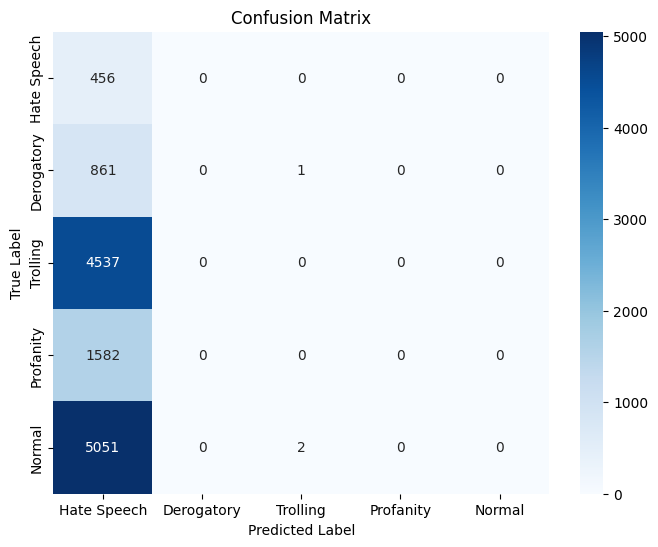

In [26]:
actual_labels = df['Majority_label'].tolist()
predicted_labels = df['Predicted_Label'].tolist()

accuracy = accuracy_score(actual_labels, predicted_labels)
print(f'Accuracy: {accuracy:.4f}')

cm = confusion_matrix(actual_labels, predicted_labels, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()